In [1]:
# Importing necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import shap
import joblib
import matplotlib.pyplot as plt

In [2]:
# Loading the dataset
df = pd.read_csv('crop_yield.csv')
# Dropping state column to adjust for state per state imbalances.
df = df.drop(columns=['State'])
df.head()

,Crop,Crop_Year,Season,State,Area,Production,Annual_Rainfall,Fertilizer,Pesticide,Yield
0,Arecanut,1997,Whole Year,Assam,73814.0,56708,2051.4,7024878.38,22882.34,0.796087
1,Arhar/Tur,1997,Kharif,Assam,6637.0,4685,2051.4,631643.29,2057.47,0.710435
2,Castor seed,1997,Kharif,Assam,796.0,22,2051.4,75755.32,246.76,0.238333
3,Coconut,1997,Whole Year,Assam,19656.0,126905000,2051.4,1870661.52,6093.36,5238.051739
4,Cotton(lint),1997,Kharif,Assam,1739.0,794,2051.4,165500.63,539.09,0.420909


In [4]:
# Defining numerical and categorical features
numerical_features = ['Area', 'Production', 'Annual_Rainfall', 'Fertilizer', 'Pesticide']
categorical_features = ['Crop', 'Season']

In [5]:
# Preprocessing pipeline
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [7]:
# Fit the preprocessor to the training data
preprocessor.fit(df.drop('Yield', axis=1))

ColumnTransformer(transformers=[('num', StandardScaler(),
                                 ['Area', 'Production', 'Annual_Rainfall',
                                  'Fertilizer', 'Pesticide']),
                                ('cat', OneHotEncoder(handle_unknown='ignore'),
                                 ['Crop', 'Season'])])

In [8]:
# Get feature names after one-hot encoding for categorical features
ohe_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
# Combine all feature names: numerical and one-hot encoded categorical features
all_feature_names = numerical_features + list(ohe_feature_names)

In [10]:
# Split the data into training and testing sets
X = df.drop('Yield', axis=1)
y = df['Yield']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [11]:
# Fit the model pipeline
model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('model', RandomForestRegressor(n_estimators=100, random_state=42))])

model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Area', 'Production',
                                                   'Annual_Rainfall',
                                                   'Fertilizer', 'Pesticide']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Crop', 'Season'])])),
                ('model', RandomForestRegressor(random_state=42))])

In [12]:
# Convert the output of the preprocessor from sparse to dense
X_train_transformed = preprocessor.transform(X_train).toarray()

In [13]:
# Create a DataFrame with the transformed data for visualization
X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=all_feature_names)
X_train_transformed_df.head()

In [15]:
# Ensure that X_test is preprocessed with the same preprocessor used for X_train
X_test_transformed = preprocessor.transform(X_test).toarray()

In [16]:
# Initialize SHAP explainer on the dense transformed data
explainer = shap.Explainer(model_pipeline.named_steps['model'], X_train_transformed)


In [17]:
# Calculate SHAP values for the dense transformed test set, bypassing the additivity check
shap_values = explainer.shap_values(preprocessor.transform(X_test).toarray(), check_additivity=False)


100%|===================| 3928/3938 [03:24<00:00]        

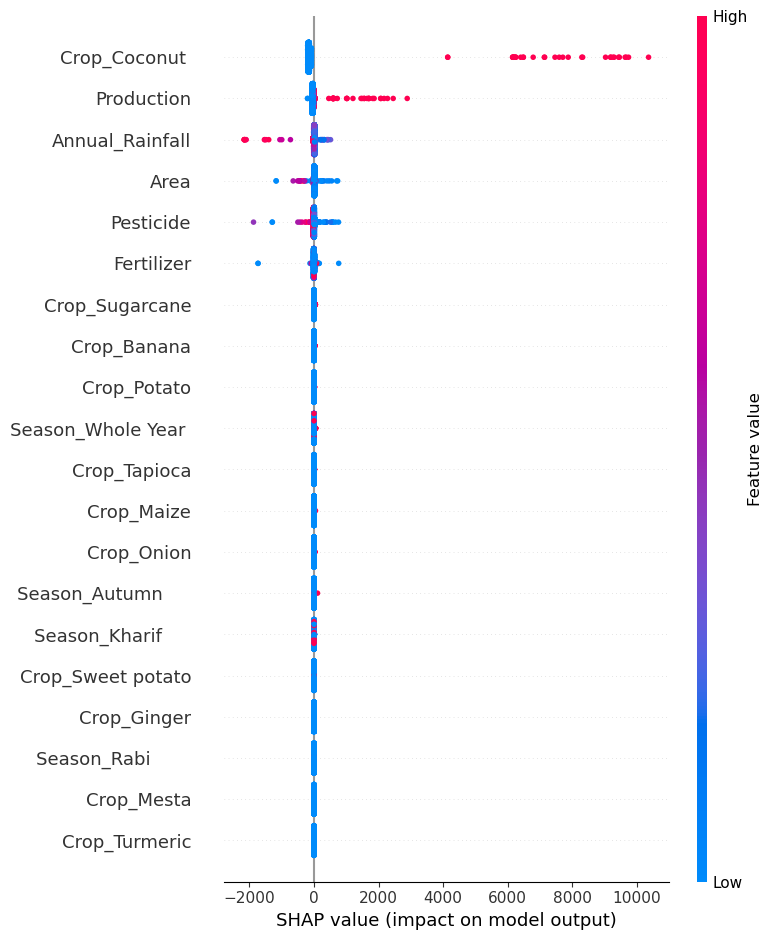

In [18]:
# Visualize SHAP summary plot
shap.summary_plot(shap_values, X_test_transformed, feature_names=all_feature_names)


In [19]:
# Predict on the testing set
y_pred = model_pipeline.predict(X_test)

In [20]:
# Print evaluation metrics # NEW METRICS WITHOUT STATE
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"R-squared score: {r2}")

Root Mean Squared Error: 108.11241282769436
Mean Absolute Error: 7.304624722409812
R-squared score: 0.9854122413033389


In [21]:
# Save the model to a file
joblib.dump(model_pipeline, 'test.pkl')

['test.pkl']

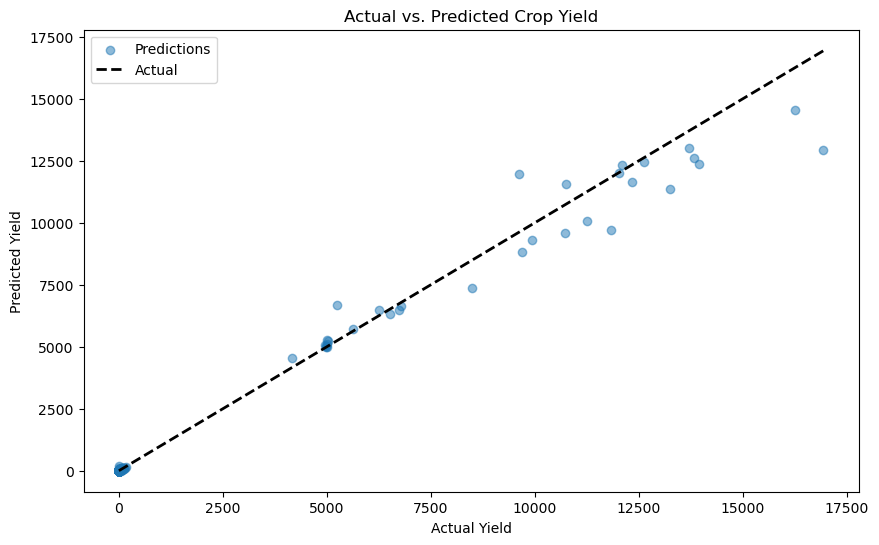

In [22]:
# Visualize actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, label='Predictions')
plt.title('Actual vs. Predicted Crop Yield')
plt.xlabel('Actual Yield')
plt.ylabel('Predicted Yield')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Actual')
plt.legend()
plt.show()

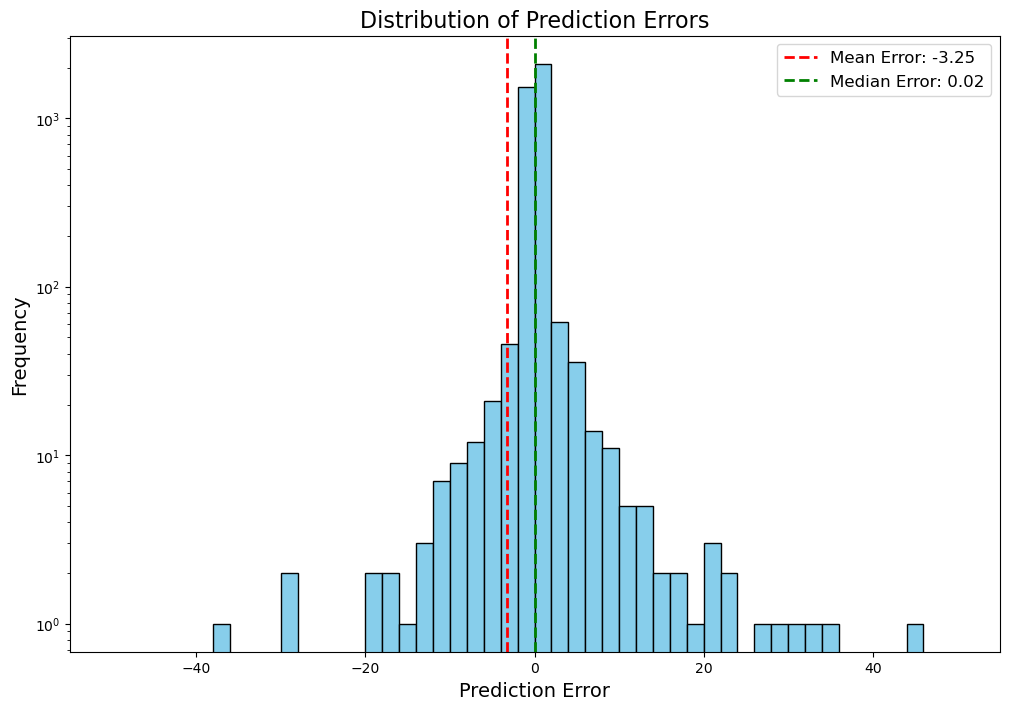

In [23]:
# Visualize distribution of prediction errors
errors = y_pred - y_test

# Calculate mean and median error
mean_error = errors.mean()
median_error = errors.median()

# Visualize distribution of prediction errors within a specific range
plt.figure(figsize=(12, 8))  # Increased figure size
hist, bins, _ = plt.hist(errors, bins=50, range=(-50, 50), color='skyblue', edgecolor='black')  # Adjusted bins and range
plt.title('Distribution of Prediction Errors', fontsize=16)
plt.xlabel('Prediction Error', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.yscale('log')  # Log scale for the frequency axis

# Add mean and median error to the plot
plt.axvline(mean_error, color='red', linestyle='dashed', linewidth=2, label=f'Mean Error: {mean_error:.2f}')
plt.axvline(median_error, color='green', linestyle='dashed', linewidth=2, label=f'Median Error: {median_error:.2f}')
plt.legend(fontsize=12)

plt.show()

In [24]:
# Calculate and display R-squared score
r2 = r2_score(y_test, y_pred)
print(f'R-squared score: {r2:.2f}')

R-squared score: 0.99


In [25]:
# Create DataFrame from errors Series
errors_df = pd.DataFrame(errors)

# Check the DataFrame
print(errors_df)

# Check for null values in errors_df
print(errors_df.isnull().sum())

# Calculate descriptive statistics
error_descriptive_stats = errors_df.describe()
print(error_descriptive_stats)

          Yield
18238 -0.199907
6918   0.121997
4894   0.059617
10960  0.152078
15615  0.029697
...         ...
8087   4.252334
14720  9.916050
9234   0.107596
19610 -0.044625
1692  -0.097099

[3938 rows x 1 columns]
Yield    0
dtype: int64
             Yield
count  3938.000000
mean     -3.249644
std     108.077286
min   -4017.130407
25%      -0.067132
50%       0.019035
75%       0.121408
max    2353.760744
